In [1]:
%load_ext autoreload
%autoreload 2

#Save result path
path='../../../../../scratch/kevin.pasini/save/'

#Native import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import datetime
import math
from sklearn.ensemble import IsolationForest
import tensorflow as tf

#Base_code import
import Base_code.Class_RF as RF
import Base_code.Class_Lstm as C_Lstm
import Base_code.score_anomalie as sa
import Base_code.Experiment as exp
import Base_code.modele as md
import Base_code.Gen_data as Gen

%matplotlib notebook

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.40)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


# Result of several experiments

In [2]:
# Choix des modèles à évaluer
Type_modele=['CAT','RF-LT','RF-ST','LSTM','EXACT']
Type_variance=['S-AE','S-RE','S-EMP','S-ML','S-RF','S-DEEP','S-EXACT']

def dict_val(Type_modele,Type_variance,modele,variance):
    return(Type_modele.index(modele),Type_modele.index(modele)*len(Type_variance)+Type_variance.index(variance))

Plan_exp={'CAT':['S-AE','S-RE','S-EMP','S-ML','S-EXACT'],
          'RF-LT':['S-AE','S-RE','S-EMP','S-ML','S-RF','S-EXACT'],
          'RF-ST':['S-AE','S-RE','S-EMP','S-ML','S-RF','S-EXACT'],
          'LSTM':['S-AE','S-RE','S-EMP','S-ML','S-DEEP','S-EXACT'],
          'EXACT':['S-AE','S-RE','S-EMP','S-ML','S-EXACT']}

Mat_exp=np.zeros((len(Type_modele),len(Type_variance)))
for i in Plan_exp:
    for j in Plan_exp[i]:
        Mat_exp[Type_modele.index(i),Type_variance.index(j)]=1

plt.figure(figsize=(3,3))  
plt.imshow(Mat_exp,cmap=plt.get_cmap('Reds'),vmin=0,vmax=1,extent=(-0.5, len(Type_variance)-0.5, -0.5, len(Type_modele)-0.5))
plt.yticks(np.arange(len(Type_modele))[::-1],Type_modele)
plt.xticks(np.arange(len(Type_variance)),Type_variance,rotation=80)
plt.tight_layout()
plt.show()

name_exp='test'

<IPython.core.display.Javascript object>

In [3]:
n_year=3
n_day=3
dim_n=366*n_year
dim_t=24
dim_g=3
dim_f=5
dim=(dim_n,dim_t,dim_g)
per=98


#Param generation
dict_param={
'c_dyn':0.2,
'n_year':n_year,
'n_day':n_day,
'var_jour':0.2,
'n_anom':int(dim_n*dim_t*0.02),
'sigma_mult':0.10,
'sigma_add':0.03,
'f_anom':1,
'anom_seuil':0,
'verbose':0,
'seas1':(dim_t*n_day),
'seas2':((dim_n*dim_t)/n_year),
'anom_point':True}


Pond_=[[1,0,0,0,0],[1,1,1,1,1],[0,4,1,1,1],[1,4,1,1,1]]
epochs=[100,1000,1000,1000]
b_s=[100,75,25,50]
l_r=[0.02,0.01,0.008,0,0.01]

verbose=True

n_score = int(Mat_exp.sum())
n_exp_ = 5
n_greed = 100
n_ech= 50

verbose=0

norm_v=np.zeros((n_exp_,9))
res_matrix_=np.zeros((n_exp_,n_score,9,4))
roc_all=np.zeros((n_exp_,n_score,dim_n*dim_t+1,4))

list_pred_result=[]

for n_exp in range(n_exp_):
    print('Opération '+str(n_exp))
    print('Génération')
    
    #Data_generation
    if(True):
        data,data_full,impact_anom,anom,anom_list,env_up,env_mid,env_inf,var_true,Variance_contexte=Gen.core_gen(c_dyn = dict_param['c_dyn'],
                                                                                       var_jour = dict_param['var_jour'],
                                                                                       n_anom = dict_param['n_anom'],
                                                                                       sigma_mult = dict_param['sigma_mult'],
                                                                                       sigma_add = dict_param['sigma_add'],
                                                                                       f_anom = dict_param['f_anom'],
                                                                                       anom_seuil = dict_param['anom_seuil'],
                                                                                       verbose = dict_param['verbose'],
                                                                                       anom_point = dict_param['anom_point'],
                                                                                       seas1=dict_param['seas1'],
                                                                                       seas2=dict_param['seas2'],
                                                                                       dim=dim)
        anom_pred=((np.abs(impact_anom).sum(axis=-1)>0).astype(int) -  (anom>0).astype(int))
    
        flag_day=np.arange(dim_n)%dict_param['n_day']
        if(anom_pred.sum()<1):
            anom_pred[0]=1
            anom_pred[-1]=1
        Y,X_lt,train,test,train_rf,test_rf=Gen.factory(data_full,seas1=dict_param['seas1'],seas2=dict_param['seas2'],dim=dim)
        norm=Y.mean(axis=0)
        dim_lt=X_lt.shape[-1]

    
    dict_res={'pred':{},'var':{},'res':{}}
    print('Learning prediction model')
    
    if('CAT' in Plan_exp.keys()):
        dict_res['pred']['CAT']=md.mean_cat(Y.reshape(dim),flag_day,train,dim_n/(12*n_year),dim_n/n_year,dim).reshape(-1,dim_g)
    
    if('RF-LT' in Plan_exp.keys()):
        X=X_lt
        Y=Y
        model=RF.RF()
        model.random_search_rf(X,Y,train_rf,test_rf,n_greed,param_set=0)
        model.fit(X[train_rf],Y[train_rf])
        model_lt=model
        dict_res['pred']['RF-LT']=model.predict(X)
        if('S-RF' in Plan_exp['RF-LT']):
            tab=np.concatenate([np.arange(0,dim_n*dim_t,int((dim_n*dim_t)/6)),[dim_n*dim_t]])
            dict_res['var']['RF-LT']=model.esti_var_rf(X,Y,train_rf,tab)
            
    if('RF-ST' in Plan_exp.keys()):
        X=Gen.factory_st(X_lt,Y,dim_f=4,dim=dim)
        Y=Y
        model=RF.RF()
        model.random_search_rf(X,Y,train_rf,test_rf,n_greed,param_set=0)
        model.fit(X[train_rf],Y[train_rf])
        dict_res['pred']['RF-ST']=model.predict(X)
        if('S-RF' in Plan_exp['RF-ST']):
            tab=np.concatenate([np.arange(0,dim_n*dim_t,int((dim_n*dim_t)/6)),[dim_n*dim_t]])
            dict_res['var']['RF-ST']=model.esti_var_rf(X,Y,train_rf,tab)
            
    if('LSTM' in Plan_exp.keys()):
        with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.60))) as sess:
            Y_all,Y_past=md.ST_factory(Y/norm,X_lt,dim_f,dim=dim,remove=False,recon=True)
            V1=X_lt.reshape(dim_n,dim_t,-1)
            LSTM=C_Lstm.Lstm(dim_n,dim_t,dim_lt,dim_g,dim_f,
                             fact_dim=[100,70,20],
                             gen_dim=[100,70,20],
                             dim_z=50,
                             dp=0.12,
                             dp_2=0.08,
                             coef_mse=1000,
                             testing=False,
                             name='0')
            
            LSTM.fit([V1,Y_past],[Y_all],train,test,epochs,b_s,l_r,n_repet=1,pond_=Pond_,verbose=0)
            pred_lstm,_,_ = LSTM.predict_variationel(V1,Y_past,norm,n_ech=n_ech)
            LSTM.modify_dropout(0.15,0.15)
            pred_lstm,var_lstm,preds=LSTM.predict_variationel(V1,Y_past,norm,n_ech=n_ech)

            dict_res['pred']['LSTM'] = pred_lstm[0]
            #dict_res['pred']['LSTM-LAG'] = pred_lstm[1]
            if(('S-DEEP' in Plan_exp['LSTM'])):
                dict_res['var']['LSTM']=var_lstm[0]
                #dict_res['var']['LSTM-LAG']=var_lstm[1]

    dict_res['var']['EXACT']=var_true
    if('EXACT' in Plan_exp.keys()):
        dict_res['pred']['EXACT']=env_mid
           
    #Affichage des résultats de prédiction
    list_pred=[]
    name_pred=[]
    list_pred_result.append(md.res_detail(Y,np.roll(Y,1,axis=0),train_rf,test_rf,[anom>0,anom_pred>0],dim_g))
    print('Last_values',list_pred_result[0])
    for name in dict_res['pred'].keys():
        list_pred.append(dict_res['pred'][name])
        name_pred.append(name)
        pred_res=md.res_detail(Y,list_pred[-1],train_rf,test_rf,[anom>0,anom_pred>0],dim_g)
        print(name,n_exp,pred_res)
        list_pred_result.append(pred_res)
    # Inférence de la variance contextuelle 
    print('Contextual variance estimation')      
    
    Var=[]
    Biais=[]
    list_r=[]
    name_score=[]
    pos_score=[]
    for n,name in enumerate(list(Plan_exp.keys())):
        print(n,name)
        r=Y-dict_res['pred'][name]

        if('S-AE' in Plan_exp[name]):
            Biais.append(np.zeros((dim_n*dim_t,dim_g)))
            Var.append(np.ones((dim_n*dim_t,dim_g)))
            list_r.append(r)
            name_score.append(name+'_S-AE')
            pos_score.append(Type_modele.index(name)*len(Type_variance)+0)

        if('S-RE' in Plan_exp[name]):
            Biais.append(np.zeros((dim_n*dim_t,dim_g)))
            Var.append(Y+1)
            list_r.append(r)
            name_score.append(name+'_S-RE')
            pos_score.append(Type_modele.index(name)*len(Type_variance)+1)

        if('S-EMP'  in Plan_exp[name]):
            a,b=sa.var_emp(r,flag_day,train_rf,dim_n/(12*n_year),dim_n/n_year,dim)
            Biais.append(a)
            Var.append(b)
            list_r.append(r)
            name_score.append(name+'_S-EMP')
            pos_score.append(Type_modele.index(name)*len(Type_variance)+2)

        if('S-ML' in Plan_exp[name]):
            #rf_mean=gd.random_search_rf(X_lt,r,train_rf,test_rf,n_greed)
            rf_mean=model_lt
            rf_mean.fit(X_lt[train_rf],r[train_rf])
            Biais.append(rf_mean.predict(X_lt))
            pos_score.append(Type_modele.index(name)*len(Type_variance)+3)

            Y_var=np.power(r-Biais[-1],2)
            #rf_var=gd.random_search_rf(X_lt,Y_var,train_rf,test_rf,n_greed)
            rf_var=model_lt
            rf_var.fit(X_lt[train_rf],Y_var[train_rf])
            Var.append(np.sqrt(rf_var.predict(X_lt)))
            list_r.append(r)
            name_score.append(name+'_S-ML')


        if('S-RF' in Plan_exp[name]):
            tab=np.concatenate([np.arange(0,dim_n*dim_t,int((dim_n*dim_t)/6)),[dim_n*dim_t]])
            Biais.append(np.zeros((dim_n*dim_t,dim_g)))
            Var.append(dict_res['var'][name])
            name_score.append(name+'_S-RF')
            list_r.append(r)
            pos_score.append(Type_modele.index(name)*len(Type_variance)+4)

        if('S-DEEP' in Plan_exp[name]):
            Biais.append(np.zeros((dim_n*dim_t,dim_g)))
            Var.append(dict_res['var'][name])
            name_score.append(name+'_S-DEEP')
            list_r.append(r)
            pos_score.append(Type_modele.index(name)*len(Type_variance)+5)

        if('S-EXACT' in Plan_exp[name]):
            Biais.append(np.zeros((dim_n*dim_t,dim_g)))
            Var.append(dict_res['var']['EXACT'])
            name_score.append(name+'_S-EXACT')
            list_r.append(r)
            pos_score.append(Type_modele.index(name)*len(Type_variance)+6)


    # Construction des scores 
    print('Score computation')
    list_s,list_v,list_ps,list_sign,list_born,name_score=exp.compute_score(Y,list_r,Biais,Var,name_score,train_rf,per=per,dim=dim,type_norm='Percentiles_local')
    
    # Calcul des résultats 
    res_matrix_,roc_all=exp.compute_res(list_s,list_v,anom,impact_anom,name_score,roc_all,res_matrix_,norm_v,n_exp,dim=dim)
    
dict_res_exp={
'dict_param':dict_param,
'Plan_exp':Plan_exp,
'Mat_exp':Mat_exp,
'list_pred_result':list_pred_result,
'n_exp_':n_exp_,
'res_matrix_':res_matrix_,
'roc_all':roc_all,
'Type_modele':Type_modele,
'Type_variance':Type_variance,
'pos_score':pos_score,
'norm_v':norm_v,
'name_score':name_score,
'per':per}

date=str(datetime.datetime.now())
pickle.dump(dict_res_exp,open(path+name_exp+date,'wb'))

Opération 0
Génération
0.22210248929991958 0.06783142851893112
Learning prediction model
Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   13.0s


Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   57.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed: 10.5min finished


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Last_values [127.28 131.77 545.94 527.94  54.58  50.67 142.22 147.13]
CAT 0 [ 83.56  86.85 507.99 494.44  29.15  46.86 102.8  106.89]
RF-LT 0 [ 79.56  87.4  486.55 498.89  26.07  50.    98.09 107.67]
RF-ST 0 [ 52.6   78.88 415.14 498.7   22.23  46.69  72.04 100.98]
LSTM 0 [ 74.56  79.64 473.31 500.76  29.91  46.4   93.16 101.73]
EXACT 0 [ 68.42  70.88 518.21 493.63  30.99  46.36  91.93  94.53]
Contextual variance estimation
0 CAT
1 RF-LT
2 RF-ST
3 LSTM
4 EXACT
Score computation
CAT_S-AE
CAT_S-RE
CAT_S-EMP
CAT_S-ML
CAT_S-EXACT
RF-LT_S-AE
RF-LT_S-RE
RF-LT_S-EMP
RF-LT_S-ML
RF-LT_S-RF
RF-LT_S-EXACT
RF-ST_S-AE
RF-ST_S-RE
RF-ST_S-EMP
RF

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   54.7s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:  2.0min finished


Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   55.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed: 10.3min finished


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Last_values [127.28 131.77 545.94 527.94  54.58  50.67 142.22 147.13]
CAT 1 [ 85.06  84.67 448.66 515.6   21.74  18.68 100.92 104.58]
RF-LT 1 [ 81.88  85.38 433.71 518.12  21.18  16.58  97.27 105.33]
RF-ST 1 [ 55.38  77.32 368.5  509.68  18.02  25.46  71.3   98.37]
LSTM 1 [ 74.81  75.92 440.5  513.68  25.01  18.32  91.98  97.59]
EXACT 1 [ 70.74  67.93 458.95 516.47  23.39  19.56  90.16  91.83]
Contextual variance estimation
0 CAT
1 RF-LT
2 RF-ST
3 LSTM
4 EXACT
Score computation
CAT_S-AE
CAT_S-RE
CAT_S-EMP
CAT_S-ML
CAT_S-EXACT
RF-LT_S-AE
RF-LT_S-RE
RF-LT_S-EMP
RF-LT_S-ML
RF-LT_S-RF
RF-LT_S-EXACT
RF-ST_S-AE
RF-ST_S-RE
RF-ST_S-EMP
RF-ST_S-ML
RF-ST_S-RF
RF-ST_S-EXACT
LSTM_S-AE
LSTM_S-RE
LSTM_S-EMP
LSTM_S-ML
LSTM_S-

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   55.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:  2.0min finished


Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   57.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed: 10.5min finished


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Last_values [127.28 131.77 545.94 527.94  54.58  50.67 142.22 147.13]
CAT 2 [ 96.    98.09 574.43 599.38  49.61  56.02 119.01 120.65]
RF-LT 2 [ 95.65  97.82 569.11 600.8   48.08  57.8  118.33 120.53]
RF-ST 2 [ 66.82  92.01 480.79 596.72  40.95  55.26  89.23 115.63]
LSTM 2 [ 88.2   93.06 562.02 592.92  51.85  57.27 111.94 116.19]
EXACT 2 [ 83.35  84.44 585.02 595.42  45.63  54.35 110.09 109.7 ]
Contextual variance estimation
0 CAT
1 RF-LT
2 RF-ST
3 LSTM
4 EXACT
Score computation
CAT_S-AE
CAT_S-RE
CAT_S-EMP
CAT_S-ML
CAT_S-EXACT
RF-LT_S-AE
RF-LT_S-RE
RF-LT_S-EMP
RF-LT_S-ML
RF-LT_S-RF
RF-LT_S-EXACT
RF-ST_S-AE
RF-ST_S-RE
RF-ST_S-EMP
RF-ST_S-ML
RF-ST_S-RF
RF-ST_S-EXACT
LSTM_S-AE
LSTM_S-RE
LSTM_S-EMP
LSTM_S-ML
LSTM_S-

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   54.4s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:  2.0min finished


Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   57.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed: 10.5min finished


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Last_values [127.28 131.77 545.94 527.94  54.58  50.67 142.22 147.13]
CAT 3 [ 76.69  77.24 450.16 486.22  25.77  37.39  93.    99.24]
RF-LT 3 [ 74.6   77.63 439.16 486.26  23.7   39.09  90.54  99.54]
RF-ST 3 [ 50.14  67.13 367.06 481.66  19.13  33.03  66.13  91.32]
LSTM 3 [ 67.54  67.67 435.41 481.76  17.36  28.07  84.63  91.72]
EXACT 3 [ 62.11  59.72 455.75 481.12  24.95  36.94  82.    86.06]
Contextual variance estimation
0 CAT
1 RF-LT
2 RF-ST
3 LSTM
4 EXACT
Score computation
CAT_S-AE
CAT_S-RE
CAT_S-EMP
CAT_S-ML
CAT_S-EXACT
RF-LT_S-AE
RF-LT_S-RE
RF-LT_S-EMP
RF-LT_S-ML
RF-LT_S-RF
RF-LT_S-EXACT
RF-ST_S-AE
RF-ST_S-RE
RF-ST_S-EMP
RF-ST_S-ML
RF-ST_S-RF
RF-ST_S-EXACT
LSTM_S-AE
LSTM_S-RE
LSTM_S-EMP
LSTM_S-ML
LSTM_S-

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   55.2s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:  2.0min finished


Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   56.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed: 10.4min finished


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Last_values [127.28 131.77 545.94 527.94  54.58  50.67 142.22 147.13]
CAT 4 [ 80.43  83.79 452.24 433.37  14.31  50.54  97.36  98.26]
RF-LT 4 [ 77.81  84.23 436.92 432.49  17.08  50.89  94.15  98.57]
RF-ST 4 [ 52.58  75.15 374.66 430.62  12.44  50.56  69.69  90.92]
LSTM 4 [ 71.91  74.68 452.03 429.12  22.7   50.68  90.54  90.43]
EXACT 4 [ 65.83  67.1  462.59 427.99  22.94  46.88  86.71  84.3 ]
Contextual variance estimation
0 CAT
1 RF-LT
2 RF-ST
3 LSTM
4 EXACT
Score computation
CAT_S-AE
CAT_S-RE
CAT_S-EMP
CAT_S-ML
CAT_S-EXACT
RF-LT_S-AE
RF-LT_S-RE
RF-LT_S-EMP
RF-LT_S-ML
RF-LT_S-RF
RF-LT_S-EXACT
RF-ST_S-AE
RF-ST_S-RE
RF-ST_S-EMP
RF-ST_S-ML
RF-ST_S-RF
RF-ST_S-EXACT
LSTM_S-AE
LSTM_S-RE
LSTM_S-EMP
LSTM_S-ML
LSTM_S-

In [4]:
list_pred=[]
name_pred=[]
#list_pred_result.append(md.res_detail(Y,np.roll(Y,1,axis=0),train_rf,test_rf,[anom>0,anom_pred>0],dim_g))
#print('Last_values',list_pred_result[0])
for name in dict_res['pred'].keys():
    list_pred.append(dict_res['pred'][name])
    name_pred.append(name)
    pred_res=md.res_detail(Y,list_pred[-1],train_rf,test_rf,[anom>0,anom_pred>0],dim_g)
    print(name,n_exp,pred_res)
    list_pred_result.append(pred_res)
# Inférence de la variance contextuelle 


CAT 4 [ 80.43  83.79 452.24 433.37  14.31  50.54  97.36  98.26]
RF-LT 4 [ 77.81  84.23 436.92 432.49  17.08  50.89  94.15  98.57]
RF-ST 4 [ 52.58  75.15 374.66 430.62  12.44  50.56  69.69  90.92]
LSTM 4 [ 71.91  74.68 452.03 429.12  22.7   50.68  90.54  90.43]
EXACT 4 [ 65.83  67.1  462.59 427.99  22.94  46.88  86.71  84.3 ]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


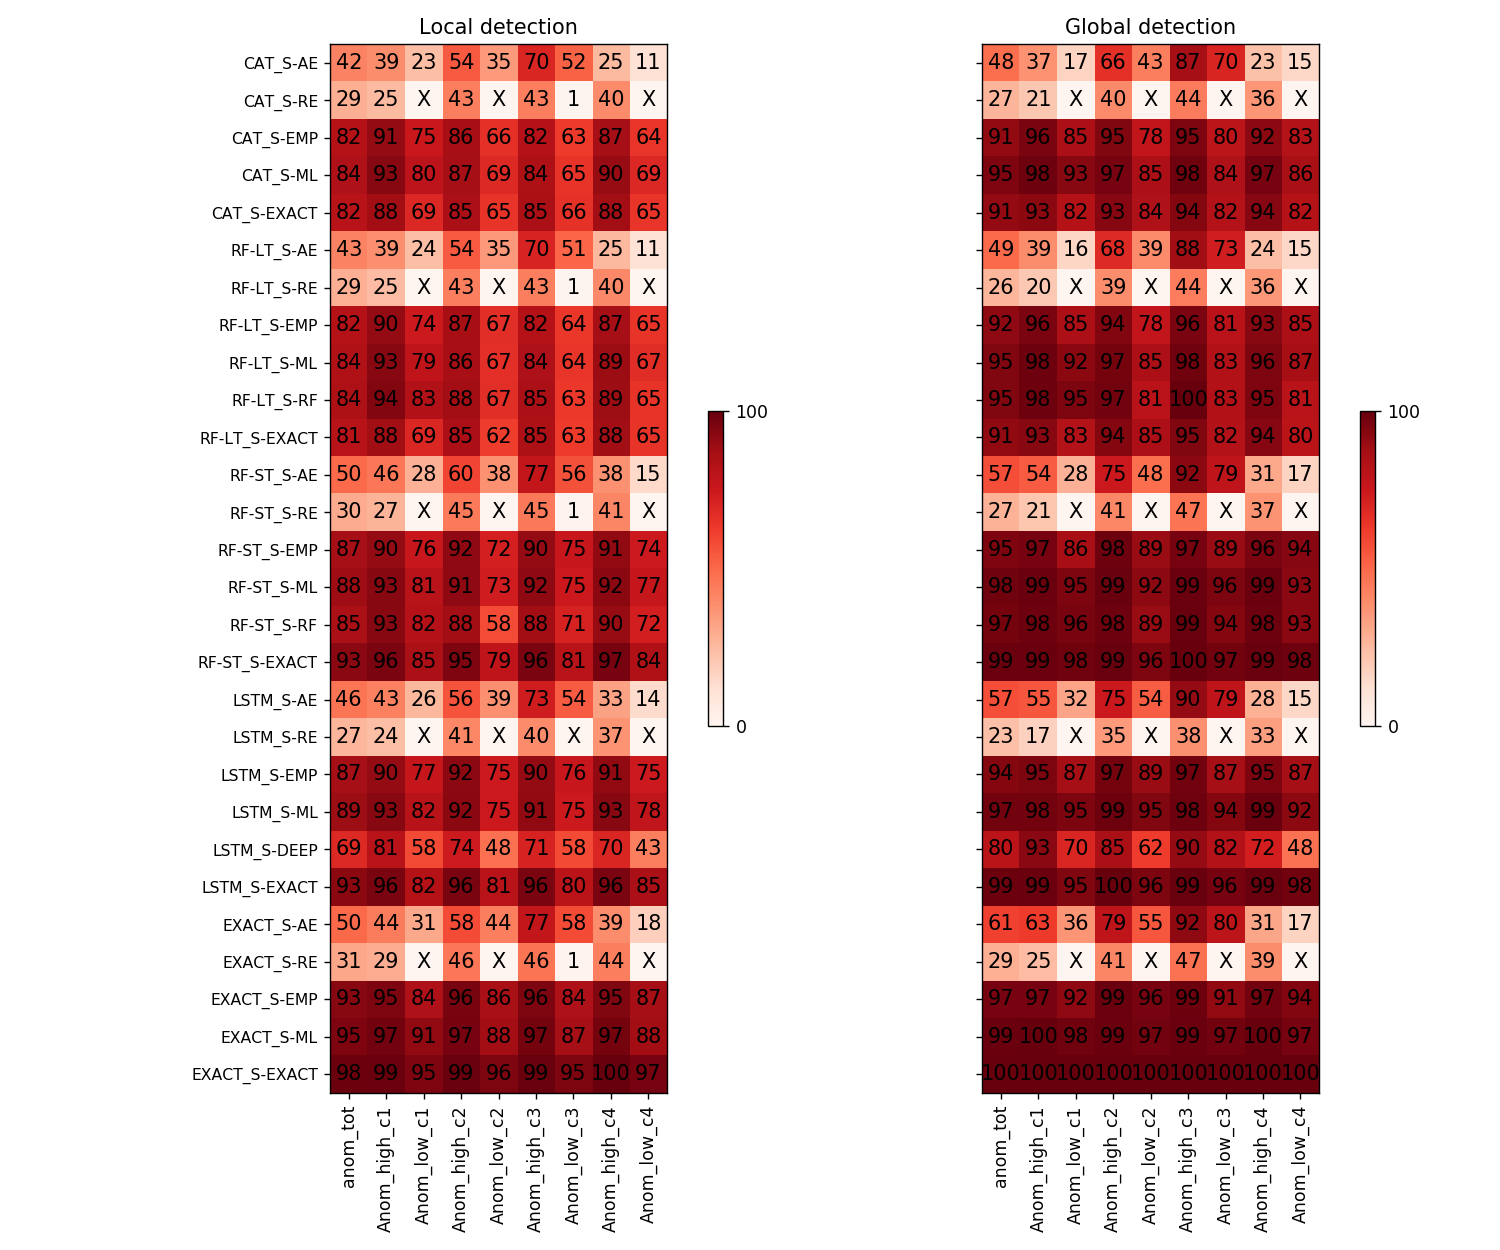

<IPython.core.display.Javascript object>


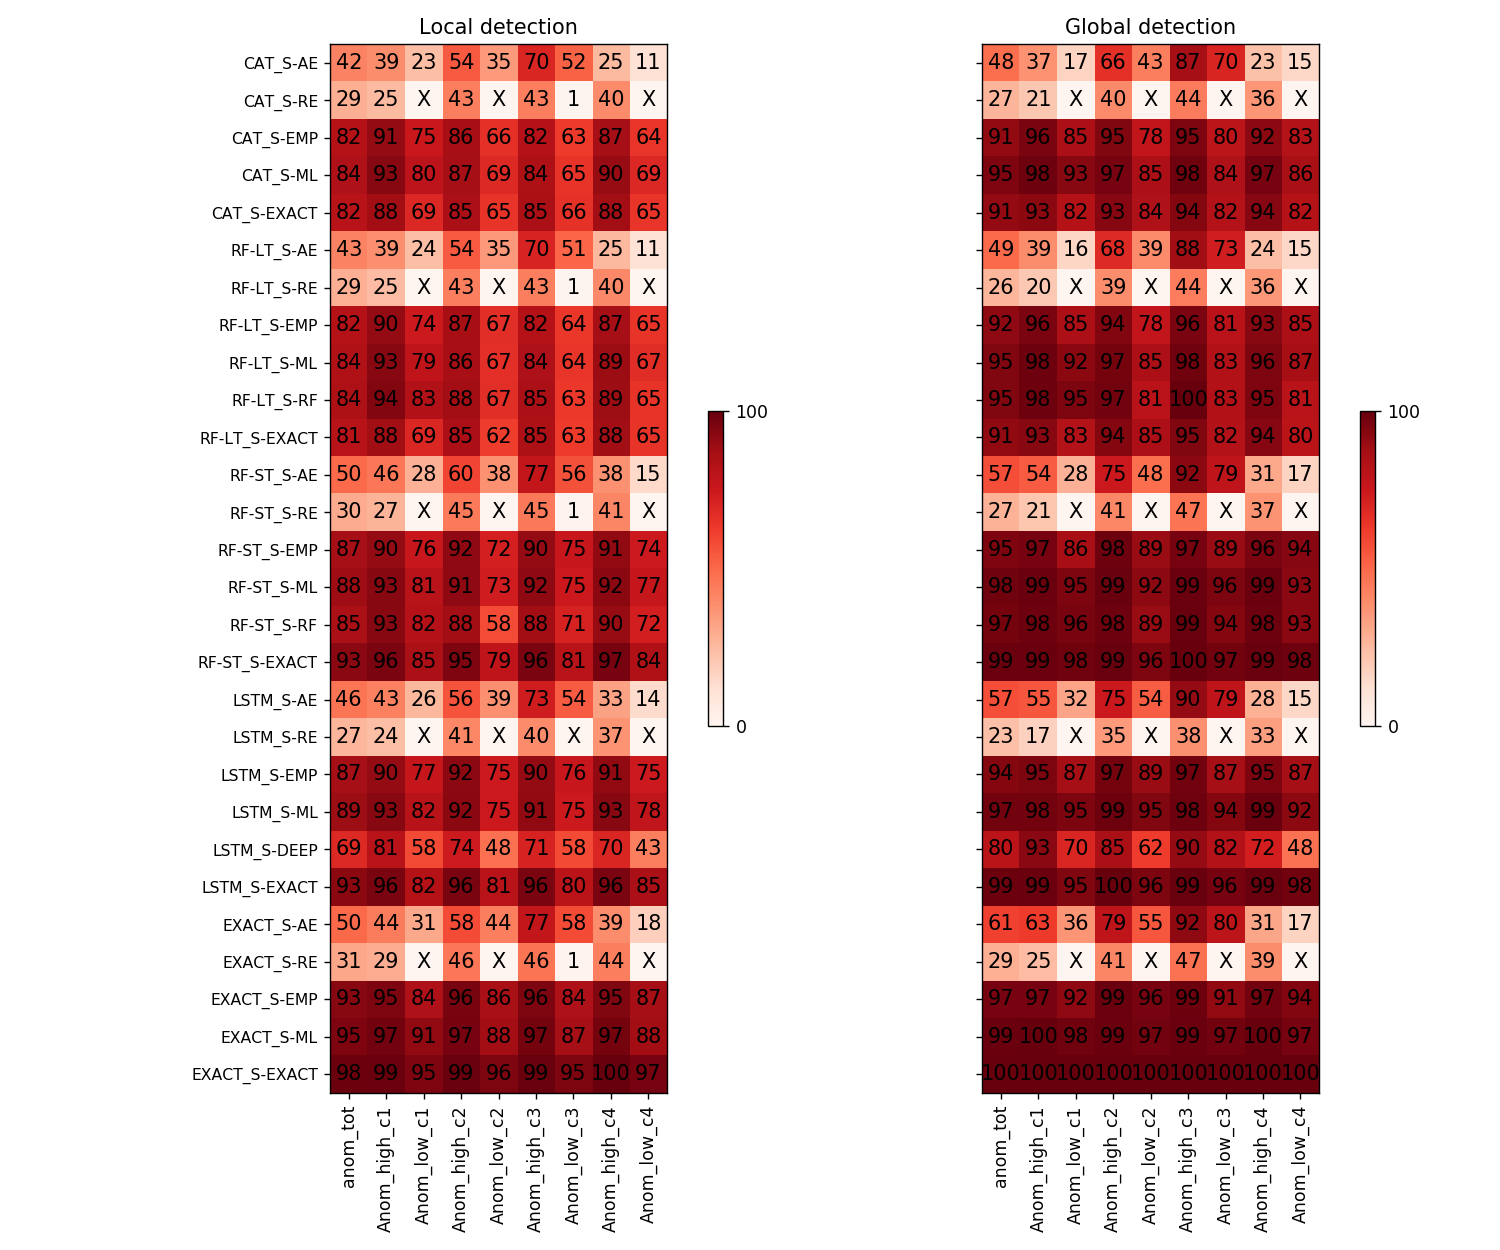

<IPython.core.display.Javascript object>

/home/kevin.pasini/Public_git/Base_code/Experiment.py:160: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/kevin.pasini/Public_git/Base_code/Experiment.py:161: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('roc')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


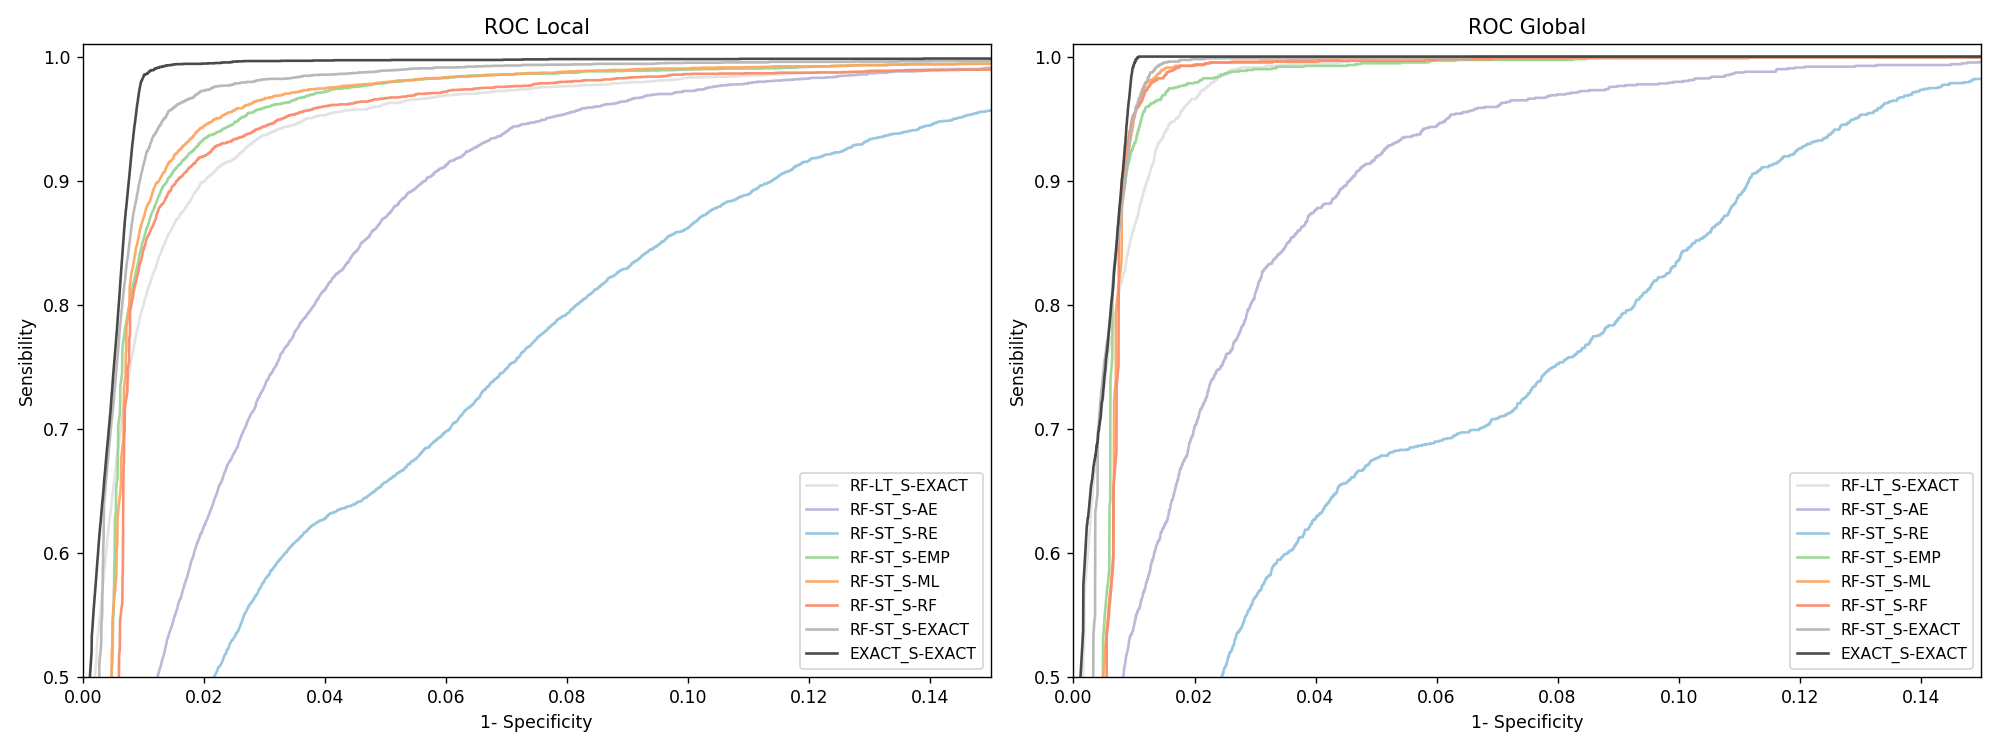

/home/kevin.pasini/Public_git/Base_code/Experiment.py:160: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/kevin.pasini/Public_git/Base_code/Experiment.py:161: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('roc')


()

In [6]:
# Flag modèle
comp_res,active_model,active_score=exp.show_mat_comp(res_matrix_,Type_modele,Type_variance,pos_score,norm_v.sum(axis=0)[0],per=per)
exp.mat_show(name_score,res_matrix_,norm_v)
exp.mat_show(name_score,res_matrix_,norm_v)
n_ac_m=active_model.sum()
color_f=[[plt.get_cmap('Purples',n_ac_m+1)(i) for i in np.arange(n_ac_m)],
[plt.get_cmap('Blues',n_ac_m+1)(i) for i in np.arange(n_ac_m)],
[plt.get_cmap('Greens',n_ac_m+1)(i) for i in np.arange(n_ac_m)],
[plt.get_cmap('Oranges',n_ac_m+1)(i) for i in np.arange(n_ac_m)],
[plt.get_cmap('Reds',n_ac_m+1)(i) for i in np.arange(n_ac_m)],
[plt.get_cmap('terrain',n_ac_m+1)(i) for i in np.arange(n_ac_m)],
[plt.get_cmap('Greys',n_ac_m+1)(i) for i in np.arange(n_ac_m)]]
color_f=[color_f[i] for i in np.arange(len(active_score))[active_score]]

color=[]
n_r=0
for nm,m in enumerate(Mat_exp):
    for nv,v in enumerate(m):
        if(v):
            nnm=np.cumsum(active_model)[nm]-1
            nnv=np.cumsum(active_score)[nv]-1
            color.append(color_f[nnv][nnm])
exp.roc_show(roc_all,name_score,n_exp_,color)

model=[ 'CAT_S-EXACT','RF-LT_S-EXACT','RF-ST_S-EXACT','LSTM_S-EXACT','EXACT_S-EXACT']
ind=[]
for n,i in enumerate(model):
    ind.append(name_score.index(i))

exp.roc_show(roc_all[:,ind,:,:],np.array(name_score)[ind],n_exp_,np.array(color)[ind])

model=['RF-LT_S-EXACT','RF-ST_S-AE','RF-ST_S-RE','RF-ST_S-EMP','RF-ST_S-ML','RF-ST_S-RF','RF-ST_S-EXACT','EXACT_S-EXACT']
ind=[]
for n,i in enumerate(model):
    ind.append(name_score.index(i))

exp.roc_show(roc_all[:,ind,:,:],np.array(name_score)[ind],n_exp_,np.array(color)[ind])
